# Streaming data

## Import Module

In [25]:
import json
import pandas as pd
import nltk
from nltk.tokenize import TweetTokenizer as tw_tokenizer
from unidecode import unidecode
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tag import CRFTagger
from spacy.lang.id import Indonesian
import taudataNlpTm as tau, itertools, re, pickle, pyLDAvis, pyLDAvis.sklearn, spacy, urllib.request
import time, numpy as np, matplotlib.pyplot as plt, networkx as nx, seaborn as sns 
from tqdm import tqdm
from textblob import TextBlob
from pprint import pprint


#SKLEARN
from sklearn.model_selection import GridSearchCV 
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from sklearn.feature_extraction.text import CountVectorizer

#Visualazation
import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

from datetime import datetime, timedelta

## Load Data

In [13]:
tweets_data = [] 
tweets_file = open('data_tweet1.txt', "r") 
for line in tweets_file:
    try:
        tweet = json.loads(line)
        if "extended_tweet" in tweet:
            text = tweet["extended_tweet"]["full_text"]
        else:
            text = tweet["text"]
        if "RT @" not in text:
            tweets_data.append(text) 
    except:
        continue
tweets_file.close()

tweets_data[0:10]

['2021/07/12 20:45:38\n6. PPKM MakeADish\n7. D-573\n8. O.O.O\n9. Official Teaser\n10. Pfizer',
 'Plis kek ini lagi ppkm anak bayik udahan dulu kek yg ulang tahun wkwk',
 '@yukheisexc untuk saat ini karena masih masa ppkm yang avail yang masker kak aku🙏🏻🙏🏻',
 'pulang kerja jam 8 pas ppkm gini ga enak bgt wkw orang jualan tutup, jalan sepi\U0001f972\U0001f972',
 '😌😌😌😌😌😌😌😌😌😌😌😌',
 'GONE GIRL (2014)\nMyscore: 8.5\nNOT ON NETFLIX \n\nSeneng banget waktu nemu film twist cakep macam ini. Ini sih wajib km nonton pas ppkm. Tentang suami yg diduga menghilangkan nyawa istrinya sendiri. Apa yg sebenarnya terjadi? Siapa pelakunya dan gmn endingnya? Nonton ber2 gih sm doi https://t.co/lzVgfOcjOI',
 'libur semester genap tp malah ppkm 😪😪😪',
 'Plis no \U0001f972',
 'PERATURAN PPKM &amp; TAAT PERATURAN PEMERINTAH https://t.co/nNZVo0NeVu lewat @YouTube',
 '20.45 #BeritaSONORA - Terungkap, Pemerintah Ternyata Siapkan Skenario Perpanjangan PPKM Darurat sampai 6 Minggu https://t.co/BwMWzkgxfc https://t.co/H

# Preprocessing

### 1. tokenization

In [14]:
tweets_data = [unidecode(text).lower() for text in tweets_data]
tokenized = [tw_tokenizer().tokenize(text) for text in tweets_data]
data = [[word for word in text if word.isalnum()] for text in tokenized]
print(data[0:10])

[['12', '38', '6', 'ppkm', 'makeadish', '7', 'd', '573', '8', 'o', 'o', 'o', '9', 'official', 'teaser', '10', 'pfizer'], ['plis', 'kek', 'ini', 'lagi', 'ppkm', 'anak', 'bayik', 'udahan', 'dulu', 'kek', 'yg', 'ulang', 'tahun', 'wkwk'], ['untuk', 'saat', 'ini', 'karena', 'masih', 'masa', 'ppkm', 'yang', 'avail', 'yang', 'masker', 'kak', 'aku'], ['pulang', 'kerja', 'jam', '8', 'pas', 'ppkm', 'gini', 'ga', 'enak', 'bgt', 'wkw', 'orang', 'jualan', 'tutup', 'jalan', 'sepi'], [], ['gone', 'girl', '2014', 'myscore', 'not', 'on', 'netflix', 'seneng', 'banget', 'waktu', 'nemu', 'film', 'twist', 'cakep', 'macam', 'ini', 'ini', 'sih', 'wajib', 'km', 'nonton', 'pas', 'ppkm', 'tentang', 'suami', 'yg', 'diduga', 'menghilangkan', 'nyawa', 'istrinya', 'sendiri', 'apa', 'yg', 'sebenarnya', 'terjadi', 'siapa', 'pelakunya', 'dan', 'gmn', 'endingnya', 'nonton', 'ber', '2', 'gih', 'sm', 'doi'], ['libur', 'semester', 'genap', 'tp', 'malah', 'ppkm'], ['plis', 'no'], ['peraturan', 'ppkm', 'taat', 'peraturan', 

### 2. Slang words

In [15]:
# with open('data/slang.txt', "r", encoding="utf-8", errors='replace') as f:
#     slangwords = f.readlines()

# slangwords = [text.strip('\n').strip().split(':') for word in slangwords]
# slangwords = {key.strip(): value.strip() for key, value in slangwords}

slangwords = dict() 
slangwords_dataframe = pd.read_csv('data/colloquial-indonesian-lexicon.csv') 
for slang, formal in zip(slangwords_dataframe['slang'], slangwords_dataframe['formal']):
    slangwords[slang] = formal 

slangword_file = open('data/slang.txt', "r").read() 
slangwords_text = slangword_file.split('\n')
# print(slangwords_text)
for slang in slangwords_text:
    split_slang = slang.split(":") 
    slangwords[split_slang[0]] = split_slang[1]
# print(slangwords)

for i, text in enumerate(data):    
    for j, word in enumerate(text):
        if word in slangwords.keys():
            data[i][j] = slangwords[word]
#             print(word, slangwords[word], data[i][j])
        
print(data[0:10])

[['12', '38', '6', 'ppkm', 'makeadish', '7', 'di', '573', '8', 'o', 'o', 'o', '9', 'official', 'teaser', '10', 'pfizer'], ['plis', 'kayak', 'ini', 'lagi', 'ppkm', 'anak', 'bayik', 'udahan', 'dulu', 'kayak', 'yang', 'ulang', 'tahun', 'wkwk'], ['untuk', 'saat', 'ini', 'karena', 'masih', 'masa', 'ppkm', 'yang', 'avail', 'yang', 'masker', 'kak', 'aku'], ['pulang', 'kerja', 'jam', '8', 'pas', 'ppkm', 'begini', 'enggak', 'enak', 'banget', 'wkw', 'orang', 'jualan', 'tutup', 'jalan', 'sepi'], [], ['gone', 'girl', '2014', 'myscore', 'not', 'on', 'netflix', 'senang', 'banget', 'waktu', 'nemu', 'film', 'twist', 'cakep', 'macam', 'ini', 'ini', 'sih', 'wajib', 'kamu', 'menonton', 'pas', 'ppkm', 'tentang', 'suami', 'yang', 'diduga', 'menghilangkan', 'nyawa', 'istrinya', 'sendiri', 'apa', 'yang', 'sebenarnya', 'terjadi', 'siapa', 'pelakunya', 'dan', 'bagaimana', 'endingnya', 'menonton', 'ber', '2', 'gih', 'sama', 'doi'], ['libur', 'semester', 'genap', 'tapi', 'malah', 'ppkm'], ['plis', 'no'], ['perat

### 3. stopwords

In [16]:
factory = StopWordRemoverFactory()

Sastrawi_StopWords_id = factory.get_stop_words()

with open('data/stopwords_id.txt', "r", encoding="utf-8", errors='replace') as f:
    stopwords_id = f.readlines()

stopwords_id = [word.strip().lower() for word in stopwords_id]

# remove_stopword = [word for word in data_filtered if word not in Sastrawi_StopWords_id]
# remove_stopword = [word for word in remove_stopword if word not in stopwords_id]
remove_stopword = [[word for word in text if word not in Sastrawi_StopWords_id] for text in data]
remove_stopword = [[word for word in text if word not in stopwords_id] for text in remove_stopword]

print(remove_stopword[0:10])

[['12', '38', '6', 'makeadish', '7', '573', '8', 'o', 'o', 'o', '9', 'official', 'teaser', '10', 'pfizer'], ['plis', 'bayik', 'udahan', 'ulang'], ['avail', 'masker', 'kak'], ['pulang', 'kerja', 'jam', '8', 'pas', 'enak', 'jualan', 'tutup', 'jalan', 'sepi'], [], ['gone', 'girl', '2014', 'myscore', 'not', 'on', 'netflix', 'senang', 'nemu', 'film', 'twist', 'cakep', 'wajib', 'menonton', 'pas', 'suami', 'diduga', 'menghilangkan', 'nyawa', 'istrinya', 'pelakunya', 'endingnya', 'menonton', 'ber', 'gih', 'doi'], ['libur', 'semester', 'genap'], ['plis', 'no'], ['peraturan', 'taat', 'peraturan', 'pemerintah'], ['terungkap', 'pemerintah', 'siapkan', 'skenario', 'perpanjangan', 'darurat', '6', 'minggu', 'via']]


In [17]:
data_filtered = [" ".join(text) for text in remove_stopword if len(text)>0]
data_filtered[0:10]

['12 38 6 makeadish 7 573 8 o o o 9 official teaser 10 pfizer',
 'plis bayik udahan ulang',
 'avail masker kak',
 'pulang kerja jam 8 pas enak jualan tutup jalan sepi',
 'gone girl 2014 myscore not on netflix senang nemu film twist cakep wajib menonton pas suami diduga menghilangkan nyawa istrinya pelakunya endingnya menonton ber gih doi',
 'libur semester genap',
 'plis no',
 'peraturan taat peraturan pemerintah',
 'terungkap pemerintah siapkan skenario perpanjangan darurat 6 minggu via',
 'sabar jang sabaaaarr']

### 4. postags 

In [27]:
data_filtered = [" ".join(text) for text in remove_stopword if len(text)>0]
print(data_filtered[0:10])

['12 38 6 makeadish 7 573 8 o o o 9 official teaser 10 pfizer', 'plis bayik udahan ulang', 'avail masker kak', 'pulang kerja jam 8 pas enak jualan tutup jalan sepi', 'gone girl 2014 myscore not on netflix senang nemu film twist cakep wajib menonton pas suami diduga menghilangkan nyawa istrinya pelakunya endingnya menonton ber gih doi', 'libur semester genap', 'plis no', 'peraturan taat peraturan pemerintah', 'terungkap pemerintah siapkan skenario perpanjangan darurat 6 minggu via', 'sabar jang sabaaaarr']


In [28]:
from spacy.lang.id import Indonesian
from nltk.tag import CRFTagger
nlp_id = Indonesian()  # Language Model
ct = CRFTagger()
ct.set_model_file('data/all_indo_man_tag_corpus_model.crf.tagger')

def NLPfilter(t, filters):
    tokens = nlp_id(t)
    tokens = [str(k) for k in tokens if len(k)>2]
    hasil = ct.tag_sents([tokens])
    return [k[0] for k in hasil[0] if k[1] in filters]

In [29]:
filters = set(['NN', 'NNP', 'NNS', 'NNPS', 'JJ'])

for i, text in enumerate(data_filtered):    
    data_filtered[i] = NLPfilter(text, filters)

data_filtered = [text for text in remove_stopword if len(text)>0]
print(data_filtered[0])
# for i, d in tqdm(enumerate(data_words)):
#     data_words[i] = NLPfilter(d,filters)

# ' '.join(data_words[0])

['12', '38', '6', 'makeadish', '7', '573', '8', 'o', 'o', 'o', '9', 'official', 'teaser', '10', 'pfizer']


In [30]:
corpus = [" ".join(text) for text in data_filtered if len(text)>0]
corpus[0:10]

['12 38 6 makeadish 7 573 8 o o o 9 official teaser 10 pfizer',
 'plis bayik udahan ulang',
 'avail masker kak',
 'pulang kerja jam 8 pas enak jualan tutup jalan sepi',
 'gone girl 2014 myscore not on netflix senang nemu film twist cakep wajib menonton pas suami diduga menghilangkan nyawa istrinya pelakunya endingnya menonton ber gih doi',
 'libur semester genap',
 'plis no',
 'peraturan taat peraturan pemerintah',
 'terungkap pemerintah siapkan skenario perpanjangan darurat 6 minggu via',
 'sabar jang sabaaaarr']

## LDA SKLEARN

In [38]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)


In [41]:
lda = LatentDirichletAllocation(n_components=2,
    random_state=0, verbose = 1, learning_method = "online", learning_decay=0.5, batch_size=100, max_iter=10)
lda.fit(X)

# get topics for some given samples:
# lda.transform(X[-2:])
# print(X)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(batch_size=100, learning_decay=0.5,
                          learning_method='online', n_components=2,
                          random_state=0, verbose=1)

In [44]:
vsm_topics = lda.transform(X)
vsm_topics

array([[0.43736812, 0.56263188],
       [0.88611857, 0.11388143],
       [0.66720591, 0.33279409],
       ...,
       [0.6537218 , 0.3462782 ],
       [0.05757466, 0.94242534],
       [0.41733784, 0.58266216]])

In [45]:
doc_topic =  [a.argmax()+1 for a in tqdm(vsm_topics)] # topic of docs
doc_topic[:10]

100%|████████████████████████████████████████████████████████████████████████| 74604/74604 [00:00<00:00, 330308.55it/s]


[2, 1, 1, 1, 1, 2, 1, 2, 2, 1]

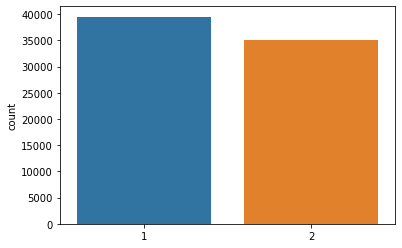

In [46]:
# mari kita plot
plot = sns.countplot(doc_topic)

In [47]:
def print_Topics(model, feature_names, Top_Topics, n_top_words):
    for topic_idx, topic in enumerate(model.components_[:Top_Topics]):
        print("Topic #%d:" %(topic_idx+1))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [48]:
X_terms = vectorizer.get_feature_names()

In [49]:
# Mari kita coba maknai masing-masing topic ini
Top_Words = 15
n_topics = 2
print('Printing top {0} Topics, with top {1} Words:'.format(n_topics, Top_Words))
print_Topics(lda, X_terms, n_topics, Top_Words)

Printing top 2 Topics, with top 15 Words:
Topic #1:
pemerintah rakyat negara vaksin bayar taliban pakai kritik gratis warga partai mural bikin jokowi agenda
Topic #2:
pemerintah vaksinasi covid pandemi masyarakat vaksin level efektif melindungi program papua kesehatan dukung kebijakan agustus


## Save and Load the Model

In [32]:
test_doc = corpus[-1]

vector = lda_model[test_doc]
print(vector)

[(0, 0.052643273), (1, 0.9208437), (2, 0.02651302)]


In [14]:
lda_model.save("lda_model/test_model.model")

In [15]:
new_model = LdaModel.load("lda_model/test_model.model")
pprint(new_model.print_topics())

[(0,
  '0.109*"mahasiswa" + 0.102*"covid" + 0.072*"19" + 0.046*"biar" + '
  '0.045*"indonesia" + 0.041*"program" + 0.035*"banget" + 0.025*"masyarakat" + '
  '0.025*"generasi" + 0.025*"gerakan"'),
 (1,
  '0.075*"2" + 0.065*"iya" + 0.043*"ppkm" + 0.035*"darurat" + 0.035*"usaha" + '
  '0.034*"lockdown" + 0.027*"dunia" + 0.027*"kadin" + 0.027*"sih" + 0.027*"1"'),
 (2,
  '0.047*"sakit" + 0.047*"rumah" + 0.041*"covid" + 0.036*"daerah" + '
  '0.035*"kesehatan" + 0.031*"19" + 0.025*"pusat" + 0.025*"sri" + '
  '0.025*"pengendalian" + 0.025*"membuka"')]


In [19]:
from sklearn.model_selection import GridSearchCV

pprint(new_model.get_params())

AttributeError: 'LdaModel' object has no attribute 'get_params'

## Visualisasi 

In [15]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2words, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.082305  0.247232       1        1  39.414047
0      0.138250 -0.220312       2        1  36.607437
1     -0.220556 -0.026920       3        1  23.978516, topic_info=       Term       Freq      Total Category  logprob  loglift
93    jalan  70.000000  70.000000  Default  30.0000  30.0000
99   rakyat  46.000000  46.000000  Default  29.0000  29.0000
51    orang  36.000000  36.000000  Default  28.0000  28.0000
46    harap  36.000000  36.000000  Default  27.0000  27.0000
112   putih  31.000000  31.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
17        2   9.422157  25.449755   Topic3  -3.7848   0.4344
54       19   4.819161   7.885563   Topic3  -4.4553   0.9356
47     kali   7.671013  26.692863   Topic3  -3.9904   0.1811
16        1   4.664083   9.807853   Topic3  -4.4880   0.6847
45    covid   4.697303  29.903481   Topic3  -4.4809  -0.4230

[133 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
16        1  0.509796        1
16        3  0.509796        1
54        2  0.380442       19
54        3  0.634070       19
17        1  0.510810        2
...     ...       ...      ...
53        2  0.961119    ujian
262       2  0.972631     urus
184       1  0.928224    usaha
263       2  0.972631  website
277       3  0.864478     zona

[112 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])